In [1]:
import msprime, tskit
from IPython.display import SVG
import numpy as np

In [2]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e5, recombination_rate=1e-8, random_seed=20)

In [3]:
ts.num_trees

9

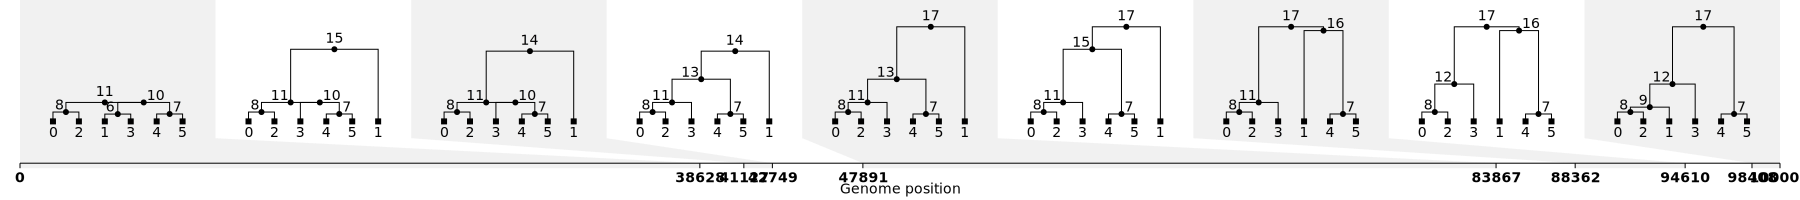

In [5]:
SVG(ts.draw_svg())

In [7]:
def extend_edges(ts):
    edgediffs = ts.edge_diffs()
    trees1 = ts.trees()
    trees2 = ts.trees()
    _ = next(trees1)
    _ = next(edgediffs)


    t = ts.tables
    edges = t.edges
    new_left = edges.left
    new_right = edges.right

    max_n = 100
    pending_out = []
    pending_in = []
    # note we skip the first tree
    for last_tree, next_tree, (interval, edges_out, edges_in) in zip(trees2, trees1, edgediffs):
        assert interval == next_tree.interval
        if False:
            print("edges_in", interval)
            for e in edges_in:
                print("-->", e)
            print("pending in", interval)
            for e in pending_in:
                print("--->", e)
            print("edges_out", interval)
            for e in edges_out:
                print("-->", e)
            print("pending out", interval)
            for e in pending_out:
                print("--->", e)
        edges_out.extend(pending_out)
        edges_in.extend(pending_in)
        pending_out = []
        pending_in = []
        extended = [False for _ in edges_out]
        for j1, e1 in enumerate(edges_out):
            # assert last_tree.parent(e1.child) == e1.parent
            if not extended[j1]:
                for j2, e2 in enumerate(edges_out):
                    if not extended[j2]:
                        if e1.parent == e2.child:
                            for e_in in edges_in:
                                if e_in.right > interval.left:
                                    # assert next_tree.parent(e_in.child) == e_in.parent
                                    if e1.child == e_in.child and e2.parent == e_in.parent:
                                        # print("     ", interval, e1.child, "-", e1.parent, "-", e2.parent, " -> ", e_in)
                                        max_n -= 1
                                        if max_n <= 0:
                                            assert False
                                        print("ping!!", e1.id, "+", e2.id, "=", e_in.id)
                                        # extend e1 and e2, postpone e_in
                                        extended[j1] = True
                                        extended[j2] = True
                                        pending_out.extend([e1, e2])
                                        pending_in.append(e_in)
                                        new_right[e1.id] = interval.right
                                        new_right[e2.id] = interval.right
                                        new_left[e_in.id] = interval.right
                                        # TODO fix up this terrible flow control 
                                        # to make sure that the same edges aren't extended more than once
    keep = new_left < new_right
    edges.set_columns(
        left=new_left[keep],
        right=new_right[keep],
        parent=edges.parent[keep],
        child=edges.child[keep])
    new_ts = t.tree_sequence()
    return new_ts

ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 25 + 33 = 30
ping!! 8 + 13 = 11
ping!! 27 + 34 = 29


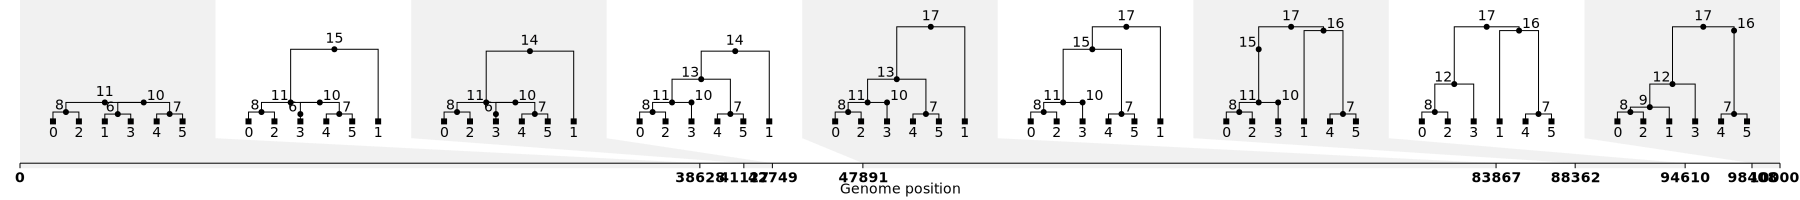

In [7]:
new_ts = extend_edges(ts)
SVG(new_ts.draw_svg())

In [8]:
def verify_extending(ts):
    ets = extend_edges(ts)
    sts = ets.simplify()
    sts.tables.assert_equals(ts.tables, ignore_provenance=True)
    print("old edges:", ts.num_edges, "new edges:", ets.num_edges)
    eets = extend_edges(ets)
    
verify_extending(ts)

ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 25 + 33 = 30
ping!! 8 + 13 = 11
ping!! 27 + 34 = 29
old edges: 35 new edges: 32
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8


In [9]:
ets = extend_edges(ts)
print("----")
eets = extend_edges(ets)
print("----")
eeets = extend_edges(eets)

ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 25 + 33 = 30
ping!! 8 + 13 = 11
ping!! 27 + 34 = 29
----
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
----


In [10]:
for seed in range(1, 100):
    print("----", seed)
    ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e5, recombination_rate=1e-8, random_seed=seed)
    verify_extending(ts)

---- 1
ping!! 10 + 13 = 11
old edges: 22 new edges: 21
---- 2
ping!! 3 + 6 = 5
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 10 + 23 = 21
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 3 + 6 = 5
old edges: 25 new edges: 22
---- 3
old edges: 22 new edges: 22
---- 4
ping!! 9 + 15 = 14
ping!! 9 + 15 = 14
ping!! 12 + 30 = 28
ping!! 6 + 21 = 18
ping!! 12 + 30 = 28
ping!! 6 + 21 = 18
ping!! 6 + 21 = 18
ping!! 20 + 38 = 37
old edges: 46 new edges: 42
---- 5
ping!! 5 + 15 = 14
ping!! 5 + 15 = 14
ping!! 3 + 14 = 13
ping!! 3 + 14 = 13
ping!! 21 + 28 = 26
ping!! 21 + 28 = 26
old edges: 33 new edges: 31
ping!! 5 + 14 = 13
ping!! 5 + 14 = 13
---- 6
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 1 + 19 = 18
ping!! 3 + 6 = 4
ping!! 21 + 30 = 28
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
ping!! 3 + 6 = 4
old edges: 40 new edges: 37
---- 7
ping!! 12 + 25 = 21
ping!! 12 + 25 = 21
ping!! 12 + 25 = 21
old edges: 32 new edges: 31
---- 8
ping!! 

ping!! 10 + 13 = 12
old edges: 18 new edges: 17
---- 61
old edges: 14 new edges: 14
---- 62
ping!! 12 + 19 = 16
ping!! 5 + 10 = 9
ping!! 5 + 10 = 9
old edges: 26 new edges: 24
---- 63
old edges: 15 new edges: 15
---- 64
ping!! 4 + 10 = 8
ping!! 4 + 10 = 8
ping!! 6 + 17 = 15
ping!! 4 + 10 = 8
ping!! 18 + 22 = 20
ping!! 4 + 10 = 8
old edges: 27 new edges: 24
---- 65
ping!! 8 + 30 = 27
ping!! 1 + 4 = 3
ping!! 11 + 24 = 20
ping!! 1 + 4 = 3
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 18 + 32 = 29
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 33 + 38 = 37
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
old edges: 40 new edges: 33
---- 66
ping!! 7 + 12 = 11
ping!! 11 + 20 = 18
ping!! 11 + 20 = 18
ping!! 1 + 29 = 28
ping!! 11 + 20 = 18
ping!! 18 + 32 = 30
ping!! 8 + 26 = 24
old edges: 40 new edges: 37
ping!! 7 + 12 = 11
ping!! 7 + 12 = 11
ping!! 7 + 12 = 

In [5]:
def extend_edges_back_pass(ts):
    edgediffs = ts.edge_diffs()
    trees1 = ts.trees()
    trees2 = ts.trees()
    _ = next(trees1)
    _ = next(edgediffs)


    t = ts.tables
    edges = t.edges
    new_left = edges.left
    new_right = edges.right

    max_n = 100
    pending_out = []
    pending_in = []
    
    ' Forward Pass through the Tree Sequence '
    # note we skip the first tree
    for last_tree, next_tree, (interval, edges_out, edges_in) in zip(trees2, trees1, edgediffs):
        assert interval == next_tree.interval
        if False:
            print("edges_in", interval)
            for e in edges_in:
                print("-->", e)
            print("pending in", interval)
            for e in pending_in:
                print("--->", e)
            print("edges_out", interval)
            for e in edges_out:
                print("-->", e)
            print("pending out", interval)
            for e in pending_out:
                print("--->", e)
        edges_out.extend(pending_out)
        edges_in.extend(pending_in)
        pending_out = []
        pending_in = []
        extended = [False for _ in edges_out]
        for j1, e1 in enumerate(edges_out):
            # assert last_tree.parent(e1.child) == e1.parent
            if not extended[j1]:
                for j2, e2 in enumerate(edges_out):
                    if not extended[j2]:
                        if e1.parent == e2.child:
                            for e_in in edges_in:
                                if e_in.right > interval.left:
                                    # assert next_tree.parent(e_in.child) == e_in.parent
                                    if e1.child == e_in.child and e2.parent == e_in.parent:
                                        # print("     ", interval, e1.child, "-", e1.parent, "-", e2.parent, " -> ", e_in)
                                        max_n -= 1
                                        if max_n <= 0:
                                            assert False
                                        print("ping!!", e1.id, "+", e2.id, "=", e_in.id)
                                        # extend e1 and e2, postpone e_in
                                        extended[j1] = True
                                        extended[j2] = True
                                        pending_out.extend([e1, e2])
                                        pending_in.append(e_in)
                                        new_right[e1.id] = interval.right
                                        new_right[e2.id] = interval.right
                                        new_left[e_in.id] = interval.right
                                        # TODO fix up this terrible flow control 
                                        # to make sure that the same edges aren't extended more than once
    
    ' Backward Pass through the Tree Sequence '
    for last_tree, next_tree, (interval, edges_out, edges_in) in zip(trees2, trees1, edgediffs):
        assert interval == next_tree.interval
        if False:
            print("edges_in", interval)
            for e in edges_in:
                print("-->", e)
            print("pending in", interval)
            for e in pending_in:
                print("--->", e)
            print("edges_out", interval)
            for e in edges_out:
                print("-->", e)
            print("pending out", interval)
            for e in pending_out:
                print("--->", e)
        edges_out.extend(pending_out)
        edges_in.extend(pending_in)
        pending_out = []
        pending_in = []
        extended = [False for _ in edges_out]
        for j1, e1 in reversed(list(enumerate(edges_out))):
            # assert last_tree.parent(e1.child) == e1.parent
            if not extended[j1]:
                for j2, e2 in reversed(list(enumerate(edges_out))):
                    if not extended[j2]:
                        if e1.parent == e2.child:
                            for e_in in reversed(edges_in):
                                if e_in.right > interval.left:
                                    # assert next_tree.parent(e_in.child) == e_in.parent
                                    if e1.child == e_in.child and e2.parent == e_in.parent:
                                        # print("     ", interval, e1.child, "-", e1.parent, "-", e2.parent, " -> ", e_in)
                                        max_n -= 1
                                        if max_n <= 0:
                                            assert False
                                        print("ping++", e1.id, "+", e2.id, "=", e_in.id)
                                        # extend e1 and e2, postpone e_in
                                        extended[j1] = True
                                        extended[j2] = True
                                        pending_out.extend([e1, e2])
                                        pending_in.append(e_in)
                                        new_right[e1.id] = interval.right
                                        new_right[e2.id] = interval.right
                                        new_left[e_in.id] = interval.right
                                        # TODO fix up this terrible flow control 
                                        # to make sure that the same edges aren't extended more than once
    
    keep = new_left < new_right
    edges.set_columns(
        left=new_left[keep],
        right=new_right[keep],
        parent=edges.parent[keep],
        child=edges.child[keep])
    new_ts = t.tree_sequence()
    return new_ts

In [9]:
nnew_ts = extend_edges_back_pass(ts)
print("----")
eets = extend_edges(ts)
print(ts.num_edges, nnew_ts.num_edges, eets.num_edges)

ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 25 + 33 = 30
ping!! 8 + 13 = 11
ping!! 27 + 34 = 29
----
ping!! 1 + 9 = 8
ping!! 1 + 9 = 8
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 8 + 13 = 11
ping!! 25 + 33 = 30
ping!! 8 + 13 = 11
ping!! 27 + 34 = 29
35 32 32


In [13]:
def verify_extending_back_pass(ts):
    ets = extend_edges_back_pass(ts)
    sts = ets.simplify()
    sts.tables.assert_equals(ts.tables, ignore_provenance=True)
    print("old edges:", ts.num_edges, "new edges:", ets.num_edges)
    eets = extend_edges_back_pass(ets)
    
verify_extending_back_pass(ts)

ping!! 8 + 14 = 10
old edges: 23 new edges: 22


In [16]:
for seed in range(1, 100):
    print("----", seed)
    ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e5, recombination_rate=1e-8, random_seed=seed)
    ets = extend_edges(ts)
    bets = extend_edges_back_pass(ts)
    verify_extending_back_pass(ts)
    print('old alg num edges: ', ets.num_edges)
    if ets.num_edges != bets.num_edges:
        print()
        print('!!!!!!!!!!!!!!!!!DIFFERENT EDGE COUNT!!!!!!!!!!!!!!!!')
        print()

---- 1
ping!! 10 + 13 = 11
ping!! 10 + 13 = 11
ping!! 10 + 13 = 11
old edges: 22 new edges: 21
old alg num edges:  21
---- 2
ping!! 3 + 6 = 5
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 10 + 23 = 21
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 3 + 6 = 5
ping!! 3 + 6 = 5
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 10 + 23 = 21
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 3 + 6 = 5
ping!! 3 + 6 = 5
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 10 + 23 = 21
ping!! 8 + 17 = 16
ping!! 3 + 6 = 5
ping!! 3 + 6 = 5
old edges: 25 new edges: 22
old alg num edges:  22
---- 3
old edges: 22 new edges: 22
old alg num edges:  22
---- 4
ping!! 9 + 15 = 14
ping!! 9 + 15 = 14
ping!! 12 + 30 = 28
ping!! 6 + 21 = 18
ping!! 12 + 30 = 28
ping!! 6 + 21 = 18
ping!! 6 + 21 = 18
ping!! 20 + 38 = 37
ping!! 9 + 15 = 14
ping!! 9 + 15 = 14
ping!! 12 + 30 = 28
ping!! 6 + 21 = 18
ping!! 12 + 30 = 28
ping!! 6 + 21 = 18
ping!! 6 + 21 = 18
ping!! 20 + 38 = 37
ping!! 9 + 15 = 14
ping!! 9 + 15 = 14
ping!! 12 + 30 = 28
ping!! 6 + 21

ping!! 7 + 41 = 40
ping!! 14 + 37 = 35
ping!! 9 + 29 = 27
ping!! 18 + 31 = 26
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 7 + 41 = 40
ping!! 14 + 37 = 35
ping!! 9 + 29 = 27
ping!! 18 + 31 = 26
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 7 + 41 = 40
ping!! 14 + 37 = 35
ping!! 9 + 29 = 27
ping!! 18 + 31 = 26
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
ping!! 4 + 23 = 21
old edges: 44 new edges: 39
old alg num edges:  39
---- 30
ping!! 2 + 17 = 15
ping!! 10 + 22 = 21
ping!! 10 + 22 = 21
ping!! 10 + 22 = 21
ping!! 2 + 17 = 15
ping!! 10 + 22 = 21
ping!! 10 + 22 = 21
ping!! 10 + 22 = 21
ping!! 2 + 17 = 15
ping!! 10 + 22 = 21
ping!! 10 + 22 = 21
ping!! 10 + 22 = 21
old edges: 36 new edges: 34
old alg num edges:  34
---- 31
ping!! 4 + 8 = 6
ping!! 4 + 8 = 6
ping!! 9 + 23 = 21
ping!! 16 + 20 = 18
ping!! 4 + 8 = 6
ping!! 4 + 8 = 6
ping!! 9 + 23 = 21
ping!! 16 + 20 = 18
ping!! 4 + 8 = 6
ping!! 4 + 8 = 6
pin

old edges: 15 new edges: 15
old alg num edges:  15
---- 64
ping!! 4 + 10 = 8
ping!! 4 + 10 = 8
ping!! 6 + 17 = 15
ping!! 4 + 10 = 8
ping!! 18 + 22 = 20
ping!! 4 + 10 = 8
ping!! 4 + 10 = 8
ping!! 4 + 10 = 8
ping!! 6 + 17 = 15
ping!! 4 + 10 = 8
ping!! 18 + 22 = 20
ping!! 4 + 10 = 8
ping!! 4 + 10 = 8
ping!! 4 + 10 = 8
ping!! 6 + 17 = 15
ping!! 4 + 10 = 8
ping!! 18 + 22 = 20
ping!! 4 + 10 = 8
old edges: 27 new edges: 24
old alg num edges:  24
---- 65
ping!! 8 + 30 = 27
ping!! 1 + 4 = 3
ping!! 11 + 24 = 20
ping!! 1 + 4 = 3
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 18 + 32 = 29
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 33 + 38 = 37
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 8 + 30 = 27
ping!! 1 + 4 = 3
ping!! 11 + 24 = 20
ping!! 1 + 4 = 3
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping!! 13 + 25 = 21
ping!! 16 + 26 = 23
ping!! 1 + 4 = 3
ping

ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 2 + 6 = 5
ping!! 19 + 29 = 25
ping!! 8 + 11 = 10
ping!! 16 + 32 = 31
ping!! 8 + 11 = 10
ping!! 9 + 20 = 18
ping!! 16 + 32 = 31
ping!! 19 + 29 = 25
ping!! 16 + 32 = 31
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 2 + 6 = 5
ping!! 19 + 29 = 25
ping!! 8 + 11 = 10
ping!! 16 + 32 = 31
ping!! 8 + 11 = 10
ping!! 9 + 20 = 18
ping!! 16 + 32 = 31
ping!! 19 + 29 = 25
ping!! 16 + 32 = 31
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 19 + 29 = 25
ping!! 2 + 6 = 5
ping!! 19 + 29 = 25
old edges: 45 new edges: 40
old alg num edges:  40
---- 92
ping!! 5 + 11 = 10
ping!! 5 + 11 = 10
ping!! 12 + 20 = 18
ping!! 5 + 11 = 10
ping!! 5 + 11 = 10
ping!! 12 + 20 = 18
ping!! 5 + 11 = 10
ping!! 5 + 11 = 10
ping!! 12 + 20 = 18
old edges: 23 new edges: 21
old alg num edges:  21
---- 93
old edges: 14 new edges: 14
old alg num edges:  14
---- 94
ping!! 6 + 25 = 23
ping!! 23 + 32 = 29
ping!

We see from running this algorithm over many trees that adding a back pass for our algorithm does not reduce edges. We should run our algorithm on more tree sequences to see if it will be useful or not.

In [17]:
old_edge = ts.num_edges
est = extend_edges_back_pass(ts)
new_edge = est.num_edges
print(old_edge, new_edge)
while old_edge > new_edge:
    old_edge = new_edge
    nest = extend_edges_back_pass(est)
    update_edge = nest.num_edges
    new_edge = update_edge
    
else:
    print('simplified tree sequence:\n', nest)

ping!! 8 + 14 = 10
23 22
simplified tree sequence:
 ╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │          6║
╟───────────────┼───────────╢
║Sequence Length│     100000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │          6║
╟───────────────┼───────────╢
║Total Size     │    2.5 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │  22│712 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│   3│108 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  15│428 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations